# Lab 7 RNN

In today's age of ocean of vast data all around us, it is crucial to extract the important and relevant information from it in proper context. In the entertainment industry specially moviews which are made for the entertainment of the people, their opinions express the sentiment and the analysis done on these opinions and reviews which are in textual form and categorising them as Positive or Negative will help in deriving overall Moview opinion that is obtained from consumer reviews. It finds applications in the fields of business intelligence, recommender systems (so as to be able to understand the sentiment in a user’s feedback), in online surveys that have natural language sentences as responses,message filtering, assessing movie review polarity, among others.
Based on these reviews and analysis done on it, can also help the directors, producers, invetors in deciding the kinds of filns they should be making and investing in which will be more likable to the people and help them generate revenue in large number.

In [1]:
import pyprind
import pandas as pd
import os
import numpy as np
import keras
import sys  
import re

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


We run the below code to generate the movie_data.csv

In [2]:
#Download from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz and save it to this folder.

basepath='./aclImdb'

labels = {'pos': 1, 'neg': 0}
pbar = pyprind.ProgBar(50000)
df = pd.DataFrame()
for s in ('test', 'train'):
     for l in ('pos', 'neg'):
        path = os.path.join(basepath, s, l)
        for file in os.listdir(path):
            with open(os.path.join(path, file), 'r',
                       encoding='utf-8') as infile:
                 txt = infile.read()
            df = df.append([[txt, labels[l]]], ignore_index=True)
            pbar.update()
df.columns = ['review', 'sentiment']
np.random.seed(0)
df = df.reindex(np.random.permutation(df.index))
df.to_csv('./movie_data.csv', index=False)

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:42


In [3]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/lisper/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
dfmain = pd.read_csv('./movie_data.csv')
df = dfmain.iloc[:30000]
print(df.shape,'df')


(30000, 2) df


In [5]:
def preprocessor(text):
    #Remove HTML
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
        
    #Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", text) 
    #
    #Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    #
    #In Python, searching a set is much faster than searching
    #   a list, so convert the stop words to a set
    stops = set(stopwords.words("english"))  #This is for speed                
    # 
    #Remove stop words
    meaningful_words = [w for w in words if not w in stops]   
    # 
    #Join the words back into one string separated by space, 
    # and return the result.
    #print(meaningful_words)
    return( " ".join( meaningful_words ))# to make the output easier to use in our Bag of Words

In [6]:
df['review'] = df['review'].apply(preprocessor)

/home/lisper/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [7]:
df['review'].head(3)

0    cure one movies rated mean everything flawless...
1    cameron mitchell plays actor dating young actr...
2    ever hear three words uttered joe baker afraid...
Name: review, dtype: object

In [8]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

NUM_TOP_WORDS = 10000

tokenizer = Tokenizer(num_words=NUM_TOP_WORDS)
tokenizer.fit_on_texts(df['review'].values)
sequences = tokenizer.texts_to_sequences(df['review'].values)

word_index = tokenizer.word_index
NUM_TOP_WORDS = len(word_index) if NUM_TOP_WORDS==None else NUM_TOP_WORDS
top_words = min((len(word_index),NUM_TOP_WORDS))
print('Found %s unique tokens. Distilled to %d top words.' % (len(word_index),top_words))

Found 81770 unique tokens. Distilled to 10000 top words.


In [9]:
maxlen = 100 # Make all sequences 100 words long
X = pad_sequences(sequences, maxlen=maxlen)
y = df['sentiment']
y_ohe = keras.utils.to_categorical(df['sentiment'])
print('Shape of data tensor:', X.shape)
print('Shape of label tensor:', y_ohe.shape)
print(np.max(X))

Shape of data tensor: (30000, 100)
Shape of label tensor: (30000, 2)
9999


# TODO 
[10 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed). Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created).   

[10 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance.

[10 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Convince me that your cross validation method is a realistic mirroring of how an algorithm would be used in practice. 

In [10]:
print(df.shape)

(30000, 2)


In [11]:
df.head()

,review,sentiment
0,cure one movies rated mean everything flawless...,1
1,cameron mitchell plays actor dating young actr...,0
2,ever hear three words uttered joe baker afraid...,0
3,road perdition movie undeservedly overlooked y...,1
4,thought nadir horror film making reached book ...,0


30000 instances and 2 features. The last column 'sentiment' is the class we want to predict based on the 'Review'. This is a case of Binary classification where based on the text of Review, Sentiment would be predicted as either of the following 2 classes:
0--> Negative
1-->Positive

These value will determine the nature of comment.

In [12]:
class_num = df['sentiment'].value_counts()

In [13]:
# see how many instances for each class we want to predict
print(class_num)

0    15006
1    14994
Name: sentiment, dtype: int64


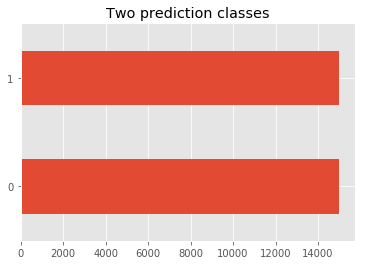

In [14]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

ax = class_num.plot(kind='barh')
plt.title('Two prediction classes')
plt.show()

> One thing to note here is that the prediction classes are equally distributed, which means no matter how we devide the test/train data, there will be no imbalance issue. We will use this fact to select our cross-validation model later.

In [16]:
# see if there are empty data that need imputation
!pip install missingno
import missingno as mn

mn.matrix(df.sort_values(by=["sentiment",]))

  Running setup.py bdist_wheel for missingno ... done
  Stored in directory: /home/lisper/.cache/pip/wheels/e7/f2/2a/767a612cde8834415d23ab484c5d069fcd0ab3a85052cda6a6
Successfully built missingno


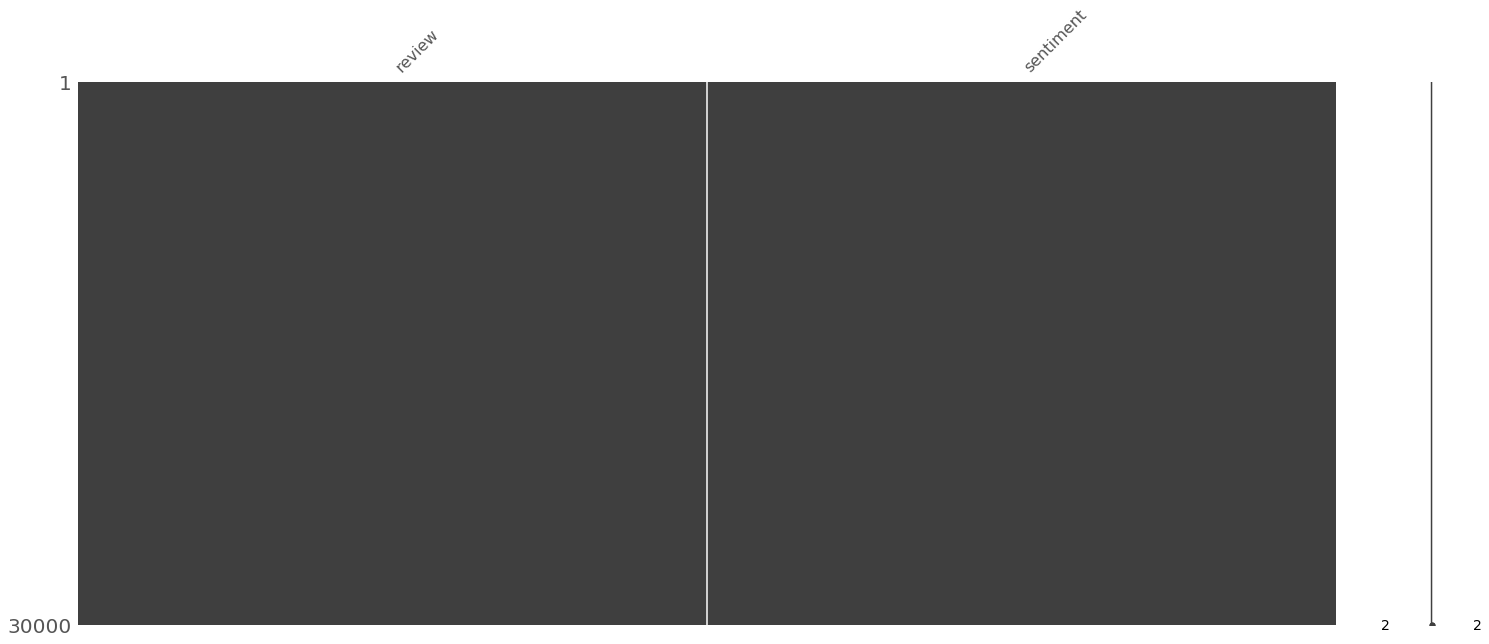

In [17]:
plt.show()

Obviously no empty data as based on the review either o or 1 is predicted by binary clasification.

In [21]:
from sklearn.model_selection import train_test_split
#bunch = df['review'].values

# Split it into train / test subsets

X_train, X_test, y_train_ohe, y_test_ohe = train_test_split(df, y_ohe, test_size=0.3)

NUM_CLASSES = y_ohe.shape[1]

print(X_train.shape,X_test.shape)
print(np.sum(y_train_ohe,axis=0))

(21000, 2) (9000, 2)
[ 10509.  10491.]


As mentioned before, the data instances in our data set are equally distributed between two prediction classes(positive vs negative), thus there will be no need for any form of stratified model(like K-fold stratified mothod). 

Also, since our dataset contains around 30000 words and we have limited time as well as computational power to do K-fold cross validation, the simpler hold out method will be a suitable method for splitting a data. That is because that if a proper data split is used for large amount of data, hold out method works good. Should we have more time or access to better computational power, we might try K-fold cross validation. This could be a 'TO-DO' item for future improment of the project. 
We tried the splitting of 80/20, 70/30 and 90/10. The best results were achieved with this 70/30 split. It is a well balanced split that keeps the model from over fitting. 
Cross avlidation will work best if we have less amount of data and need it to be divided properly such that all the data will get a chance to get into training set. Since we have a relatively big dataset (30000), in our case hold out method will be surficient.   

In [22]:
%%time
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
# select model
clf = LogisticRegression()
#select cross validation
#cv = KFold(n_splits=10, shuffle=False, random_state=None).split(X_train, y_train)

per_fold_eval_criteria = cross_val_score(estimator=clf,
                                    X=X_train,
                                    y=y_train,
                                    #cv=cv,#integer, to specify the number of folds in a (Stratified)KFold
                                    scoring='accuracy')

print('Accuracy', np.mean(per_fold_eval_criteria), per_fold_eval_criteria)

plt.bar(range(len(per_fold_eval_criteria)),per_fold_eval_criteria)
plt.ylim([min(per_fold_eval_criteria)-0.01,max(per_fold_eval_criteria)])

NameError: name 'y_train' is not defined

For our dataset, we are performing abinary classification where both the classes have equal importance as it would be difficult to argue whether positive review is more important than negative or vice-versa as both have their own important role to play in sentiment analysis done based on the review coments and these comments express the same range of opinions and subjectivity. Also, for movie reviews, there are not much difference between False Negatives(FN)and False Positives(FP) and they wont affect much. What people want from the classification is to honestly see how much people love or hate a movie. Therefore, in our case, "Accuracy" is considered to be good for evaluation criteria.


To explore the idea, we made a Cost Matrix like below:

| Cost	| Predict No 	| Predict Yes	|
|----	|----	|----	|
| Actual No 	| -10 	| 1 	|
| Actual Yes 	| 1 	| -10 	|

As we can see from the above matrix,
If the review comment is negative and is predicted as Negative (True Negative)('0' for our case ) else, if the review comment is positive and based on sentiment analysis is predicted to be Positive (True Positive)('1' for our case), both the cases it helps us by actually reducing the cost, so we give both -10 cost.

In cases of False Poisitive and False Negative, it's not good for us but can be considered OK as these might be resulted from the comments which are not too extreme Positive/Negative and neutral in nature hence will not contribute towards the cost much. So we alloted small amount of cost to it as 1 as the loss suffered due to it is not impactful.

However, it is worth to explore other varients of sentiment classification problems. If we are talking about other category of reviews, like Amazon merchandise review, people may pay much more attention to negative reviews than positive reviews. For seller, they need to single out negative reviews so valuable customer feedback can be extracted to improve the product or services. For customer, they are more concerned about whether the product have some flaw that will be a deal breaker for them. In this case, a false possitive bare much more weight than a false negative. Since if the model predict a reveiw as positive while it's actually negative, missing one valuable negative reviews might cause the seller or buyer more. The Cost Matrix looks like thi:

| Cost	| Predict No 	| Predict Yes	|
|----	|----	|----	|
| Actual No 	| -10 	| 20 	|
| Actual Yes 	| 5 	| -10 	|


In [51]:
#Using because train and test split already provided.
X_train = X[:25000]
y_train_ohe = y_ohe[:25000]
y_train = y[:25000]
X_test = X[25000:]
y_test_ohe = y_ohe[25000:]
y_test = y[25000:]


NUM_CLASSES = y_ohe.shape[1]

# Modelling

[15 points] Investigate at least two different recurrent network architectures (perhaps LSTM and GRU). Be sure to use an embedding layer (pre-trained, from scratch, or both). Adjust hyper-parameters of the networks as needed to improve generalization performance.

[15 points] Using the best RNN parameters and architecture, add a second recurrent chain to your RNN. The input to the second chain should be the output sequence of the first chain. Visualize the performance of training and validation sets versus the training iterations. 

[20 points] Use the method of cross validation and evaluation criteria that you argued for at the beginning of the lab. Visualize the results of all the RNNs you trained.  Use proper statistical comparison techniques to determine which method(s) is (are) superior.  

In [59]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


def plot_performance(history): 
    from matplotlib import pyplot as plt

    %matplotlib inline

    plt.figure(figsize=(10,4))
    plt.subplot(2,2,1)
    plt.plot(history.history['acc'])

    plt.ylabel('Accuracy %')
    plt.title('Training')
    plt.subplot(2,2,2)
    plt.plot(history.history['val_acc'])
    plt.title('Validation')

    plt.subplot(2,2,3)
    plt.plot(history.history['loss'])
    plt.ylabel('MSE Training Loss')
    plt.xlabel('epochs')

    plt.subplot(2,2,4)
    plt.plot(history.history['val_loss'])
    plt.xlabel('epochs')
    
def summarize_net(net, X_test, y_test, title_text=''):
    plt.figure(figsize=(15,5))
    yhat = np.argmax(net.predict(X_test), axis=1)
    acc = mt.accuracy_score(y_test,yhat)
    cm = mt.confusion_matrix(y_test,yhat)
    cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
    sns.heatmap(cm, annot=True, fmt='.2f')
    plt.title(title_text+'{:.4f}'.format(acc))

In [60]:
%%time
#Download from here : http://nlp.stanford.edu/data/glove.6B.zip

EMBED_SIZE = 100
# the embed size should match the file you load glove from
embeddings_index = {}
f = open('./glove.6B/glove.6B.100d.txt', encoding="utf-8")
# save key/array pairs of the embeddings
#  the key of the dictionary is the word, the array is the embedding
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.
CPU times: user 9.63 s, sys: 327 ms, total: 9.95 s
Wall time: 10.1 s


In [61]:
# now fill in the matrix, using the ordering from the
#  keras word tokenizer from before
embedding_matrix = np.zeros((len(word_index) + 1, EMBED_SIZE))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

print(embedding_matrix.shape)

(101246, 100)


In [62]:
from keras.layers import Embedding

embedding_layer = Embedding(len(word_index) + 1,
                            EMBED_SIZE,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=False)

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

rnn = Sequential()
rnn.add(embedding_layer)
rnn.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 10,205,202
Trainable params: 80,602
Non-trainable params: 10,124,600
_________________________________________________________________
None


In [64]:
history_1 = rnn.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

ValueError: Error when checking input: expected embedding_5_input to have shape (100,) but got array with shape (2,)

In [ ]:
plot_performance(history_1)

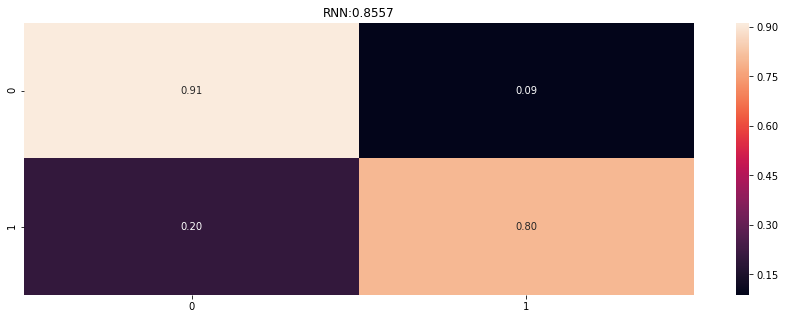

In [23]:
summarize_net(rnn, X_test, y_test, title_text='RNN:')

In [24]:
from keras.layers import Dropout

rnn2 = Sequential()
rnn2.add(embedding_layer)
rnn2.add(LSTM(100,dropout=0.2, recurrent_dropout=0.2))
rnn2.add(Dense(100, activation='relu'))
rnn2.add(Dropout(0.2))
rnn2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn2.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 202       
Total params: 10,215,302
Trainable params: 90,702
Non-trainable params: 10,124,600
_________________________________________________________________
None


In [25]:
history_2 = rnn2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 91s 4ms/step - loss: 0.5640 - acc: 0.7138 - val_loss: 0.4527 - val_acc: 0.7886
Epoch 2/10
25000/25000 [==============================] - 81s 3ms/step - loss: 0.4701 - acc: 0.7787 - val_loss: 0.3930 - val_acc: 0.8259
Epoch 3/10
25000/25000 [==============================] - 83s 3ms/step - loss: 0.4184 - acc: 0.8102 - val_loss: 0.3811 - val_acc: 0.8265
Epoch 4/10
25000/25000 [==============================] - 79s 3ms/step - loss: 0.3866 - acc: 0.8256 - val_loss: 0.3524 - val_acc: 0.8470
Epoch 5/10
25000/25000 [==============================] - 78s 3ms/step - loss: 0.3632 - acc: 0.8382 - val_loss: 0.3432 - val_acc: 0.8513
Epoch 6/10
25000/25000 [==============================] - 77s 3ms/step - loss: 0.3448 - acc: 0.8500 - val_loss: 0.3334 - val_acc: 0.8580
Epoch 7/10
25000/25000 [==============================] - 77s 3ms/step - loss: 0.3280 - acc: 0.8584 - val_loss: 0.3312 - val_acc

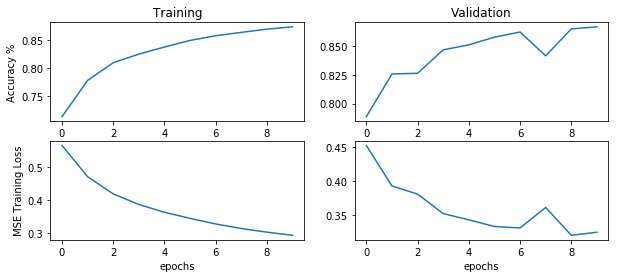

In [26]:
plot_performance(history_2)

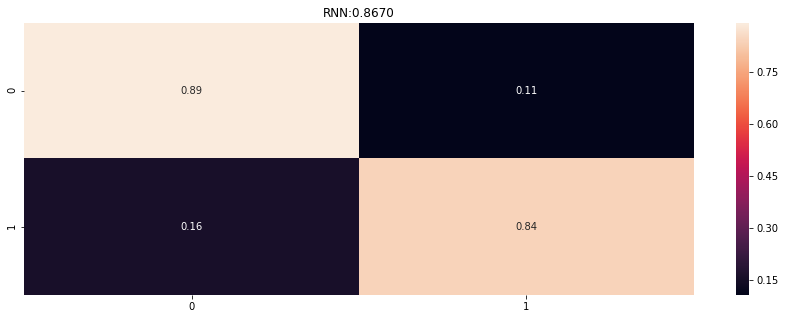

In [27]:
summarize_net(rnn2, X_test, y_test, title_text='RNN:')

# GRU

In [28]:
from keras.layers import GRU

rnn_gru = Sequential()
rnn_gru.add(embedding_layer)
rnn_gru.add(GRU(100, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_gru.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_gru.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 10,205,202
Trainable params: 80,602
Non-trainable params: 10,124,600
_________________________________________________________________
None


In [29]:
history_3 = rnn_gru.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 70s 3ms/step - loss: 0.5266 - acc: 0.7301 - val_loss: 0.3939 - val_acc: 0.8224
Epoch 2/10
25000/25000 [==============================] - 67s 3ms/step - loss: 0.4060 - acc: 0.8154 - val_loss: 0.3624 - val_acc: 0.8382
Epoch 3/10
25000/25000 [==============================] - 69s 3ms/step - loss: 0.3701 - acc: 0.8352 - val_loss: 0.3441 - val_acc: 0.8489
Epoch 4/10
25000/25000 [==============================] - 74s 3ms/step - loss: 0.3507 - acc: 0.8446 - val_loss: 0.3241 - val_acc: 0.8593
Epoch 5/10
25000/25000 [==============================] - 74s 3ms/step - loss: 0.3297 - acc: 0.8558 - val_loss: 0.3333 - val_acc: 0.8544
Epoch 6/10
25000/25000 [==============================] - 77s 3ms/step - loss: 0.3204 - acc: 0.8624 - val_loss: 0.3268 - val_acc: 0.8586
Epoch 7/10
25000/25000 [==============================] - 81s 3ms/step - loss: 0.3038 - acc: 0.8701 - val_loss: 0.3062 - val_acc

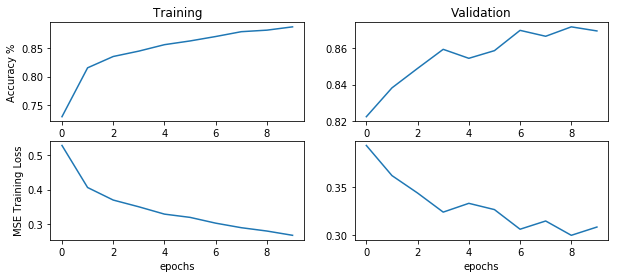

In [30]:
plot_performance(history_3)

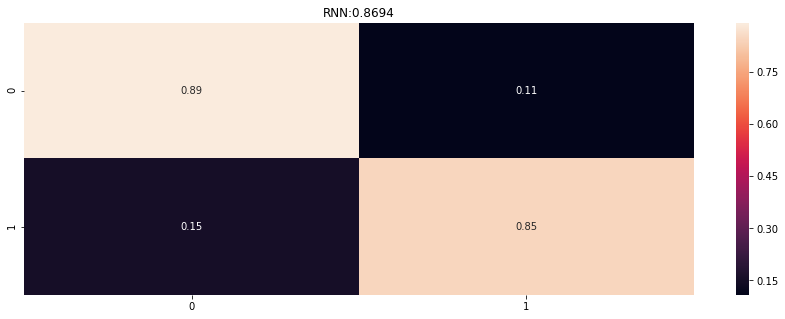

In [31]:
summarize_net(rnn_gru, X_test, y_test, title_text='RNN:')

In [32]:
rnn_gru2 = Sequential()
rnn_gru2.add(embedding_layer)
rnn_gru2.add(GRU(200, dropout=0.2, 
                     recurrent_dropout=0.2,
                     return_sequences=False))
rnn_gru2.add(Dense(NUM_CLASSES, activation='sigmoid'))
rnn_gru2.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])
print(rnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          10124600  
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 202       
Total params: 10,205,202
Trainable params: 80,602
Non-trainable params: 10,124,600
_________________________________________________________________
None


In [33]:
history_4 = rnn_gru2.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=10, batch_size=64)

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 78s 3ms/step - loss: 0.5184 - acc: 0.7412 - val_loss: 0.4724 - val_acc: 0.7682
Epoch 2/10
25000/25000 [==============================] - 75s 3ms/step - loss: 0.4002 - acc: 0.8180 - val_loss: 0.3527 - val_acc: 0.8434
Epoch 3/10
25000/25000 [==============================] - 77s 3ms/step - loss: 0.3605 - acc: 0.8402 - val_loss: 0.3641 - val_acc: 0.8378
Epoch 4/10
25000/25000 [==============================] - 76s 3ms/step - loss: 0.3363 - acc: 0.8517 - val_loss: 0.3465 - val_acc: 0.8492
Epoch 5/10
25000/25000 [==============================] - 76s 3ms/step - loss: 0.3179 - acc: 0.8618 - val_loss: 0.3121 - val_acc: 0.8660
Epoch 6/10
25000/25000 [==============================] - 76s 3ms/step - loss: 0.2968 - acc: 0.8709 - val_loss: 0.3102 - val_acc: 0.8659
Epoch 7/10
25000/25000 [==============================] - 77s 3ms/step - loss: 0.2819 - acc: 0.8781 - val_loss: 0.3118 - val_acc

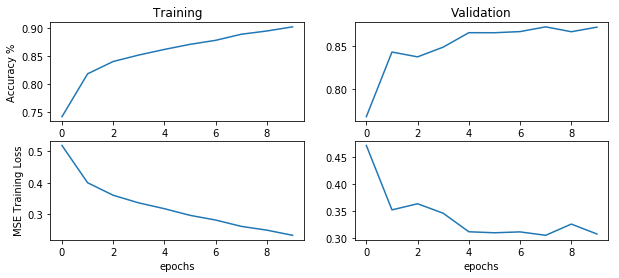

In [34]:
plot_performance(history_4)

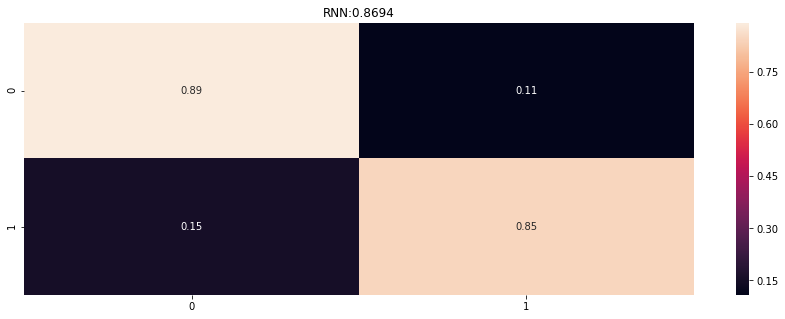

In [35]:
summarize_net(rnn_gru, X_test, y_test, title_text='RNN:')

# Reference

1. https://github.com/rasbt/python-machine-learning-book/blob/master/code/optional-py-scripts/ch08.py
2. https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch08/ch08.ipynb
3. https://cs224d.stanford.edu/reports/TimmarajuAditya.pdf